# Model 04

In [ ]:
### Model 2: Multi-Class Classification for Other Wheat Diseases  

Model 4 (M4) is a multi-class classification model that focuses on identifying **other wheat diseases** beyond rust. It categorizes the disease into four classes:  

- **Fusarium** 🌾🔴  
- **Loose Smut** 🌾⚫  
- **Septoria** 🍃🟢  
- **Common Root Rot** 🌱🟤  

This model helps in accurately detecting and differentiating these diseases, supporting early intervention and effective crop management.

In [16]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.combine import SMOTETomek
from tensorflow.keras.preprocessing import image
from collections import Counter
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set dataset paths
DATASET_PATH = r"C:\Users\VECTUS\OneDrive\Desktop\Imp\D4"  # Change this to your dataset directory
IMG_SIZE = (224, 224)  # Standard size for CNNs (EfficientNet, ResNet)
BATCH_SIZE = 32

# Function to load images and labels from directory
def load_dataset(dataset_path, img_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))
    class_counts = {class_name: 0 for class_name in class_names}  # To count images per class
    
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            images.append(img_array)
            labels.append(class_names.index(class_name))
            class_counts[class_name] += 1  # Increment count for this class
    
    return np.array(images), np.array(labels), class_names, class_counts

# Load the dataset
X_data, y_data, class_names, class_counts = load_dataset(DATASET_PATH, IMG_SIZE)

# Display class names and number of images in each class
print("Class distribution in the dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Apply SMOTE and Tomek Links for balancing
smote_tomek = SMOTETomek(random_state=42)
X_balanced, y_balanced = smote_tomek.fit_resample(X_data.reshape(X_data.shape[0], -1), y_data)
X_balanced = X_balanced.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)

# Split the balanced data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, train_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTrain set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

# Create new ImageDataGenerators for training, validation, and testing with the respective data
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Use the `flow` method to load the data into the generator
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

print("\nData generators are ready for training, validation, and testing.")


Class distribution in the dataset:
Common Root Rot: 150 images
Fusarium: 230 images
Loose Smut: 251 images
Septoria: 890 images

Train set: 2136 images
Validation set: 712 images
Test set: 712 images

Data generators are ready for training, validation, and testing.


In [17]:
# Function to extract features using a pre-trained model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

def extract_features(images, model):
    """
    Extract features from images using a pre-trained model.
    :param images: Input images (numpy array).
    :param model: Pre-trained model for feature extraction.
    :return: Extracted features (numpy array).
    """
    features = model.predict(images, verbose=1)
    return features

# Load a pre-trained model (EfficientNetB0) without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Extract features for train, validation, and test sets
print("\nExtracting features for the train set...")
X_train_features = extract_features(X_train, base_model)

print("Extracting features for the validation set...")
X_val_features = extract_features(X_val, base_model)

print("Extracting features for the test set...")
X_test_features = extract_features(X_test, base_model)



Extracting features for the train set...
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 334ms/step
Extracting features for the validation set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step
Extracting features for the test set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step


In [18]:
# Define the Self-Attention Mechanism
from tensorflow.keras.layers import Layer, Dense, Multiply, Activation


# Build the Model with Attention
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

def build_model_with_attention(input_shape, num_classes):
    model = Sequential()
    
    # Add the Self-Attention layer
    model.add(SelfAttention(units=128))
    
    # Add a Dense layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [19]:
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, 1),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.matmul(score, self.V), axis=1)
        
        # Apply attention weights to the input
        context_vector = attention_weights * inputs
        return context_vector


In [20]:
# Build the model with attention
input_shape = X_train_features.shape[1:]  # Shape of the extracted features
model_with_attention = build_model_with_attention(input_shape, len(class_names))

# Compile the model
model_with_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_with_attention.fit(X_train_features, y_train,
                                  validation_data=(X_val_features, y_val),
                                  epochs=20,
                                  verbose=1)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7819 - loss: 0.5293 - val_accuracy: 0.9705 - val_loss: 0.1015
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9862 - loss: 0.0460 - val_accuracy: 0.9831 - val_loss: 0.0644
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9949 - loss: 0.0237 - val_accuracy: 0.9860 - val_loss: 0.0658
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0192 - val_accuracy: 0.9860 - val_loss: 0.0563
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0090 - val_accuracy: 0.9888 - val_loss: 0.0500
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0096 - val_accuracy: 0.9874 - val_loss: 0.0535
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 0.9874 - val_loss: 0.0557
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0064 - val_accuracy: 0.9874 - val_loss:

In [21]:
# Evaluate the model
test_loss, test_accuracy = model_with_attention.evaluate(X_test_features, y_test)
print(f"Test Accuracy with Attention: {test_accuracy * 100:.2f}%")

# Make predictions on the test set
y_pred_attention = model_with_attention.predict(X_test_features)
y_pred_attention = np.argmax(y_pred_attention, axis=1)

# Evaluate the accuracy of the predictions
accuracy_attention = accuracy_score(y_test, y_pred_attention)
print(f"Model with Attention Accuracy: {accuracy_attention * 100:.2f}%")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0079 
Test Accuracy with Attention: 99.86%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model with Attention Accuracy: 99.86%



Plotting confusion matrix...


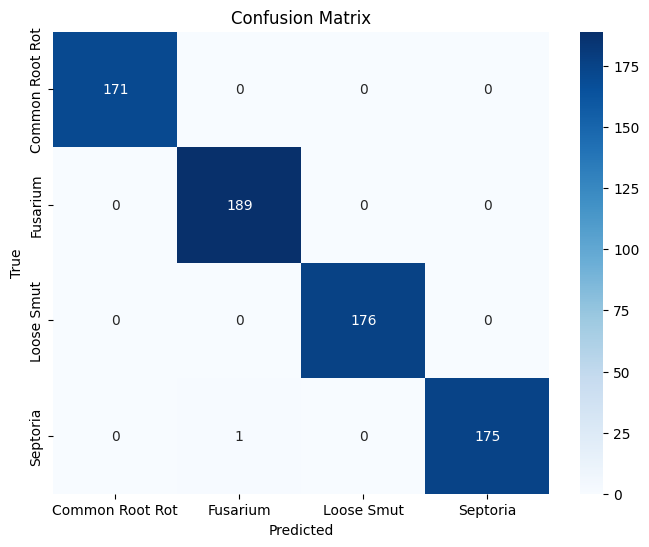

In [23]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a confusion matrix using seaborn and matplotlib.
    :param y_true: True labels.
    :param y_pred: Predicted labels.
    :param class_names: List of class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot the confusion matrix
print("\nPlotting confusion matrix...")
plot_confusion_matrix(y_test, y_pred_attention, class_names)

In [24]:
from sklearn.metrics import classification_report, accuracy_score

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_attention)

# Compute classification report (includes precision, recall, F1-score)
report = classification_report(y_test, y_pred_attention, target_names=class_names)

# Display results
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(report)



Overall Accuracy: 0.9986

Classification Report:

                 precision    recall  f1-score   support

Common Root Rot       1.00      1.00      1.00       171
       Fusarium       0.99      1.00      1.00       189
     Loose Smut       1.00      1.00      1.00       176
       Septoria       1.00      0.99      1.00       176

       accuracy                           1.00       712
      macro avg       1.00      1.00      1.00       712
   weighted avg       1.00      1.00      1.00       712



In [25]:
print("Okay Done")

Okay Done


In [26]:
from tensorflow.keras.models import save_model
# Save the final model
model_save_path = r"C:\Users\VECTUS\OneDrive\Desktop\Imp\m4.h5"  # Change this to your desired save path
model_with_attention.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:\Users\VECTUS\OneDrive\Desktop\Imp\m4.h5


In [43]:
print 

Overall Accuracy: 0.9775

Classification Report:

                 precision    recall  f1-score   support

Common Root Rot       0.99      0.99      0.99       167
       Fusarium       0.98      0.99      0.99       172
     Loose Smut       1.00      0.99      0.99       190
         Mildew       0.95      0.98      0.96       184
       Septoria       0.97      0.94      0.95       175

       accuracy                           0.98       888
      macro avg       0.98      0.98      0.98       888
   weighted avg       0.98      0.98      0.98       888

